# User Defined Reactions in MUSICA
There is an additional type of reaction in MUSICA called User Defined reactions, which are a more flexible type of reaction that supports defining per-grid-cell reaction rates.</br>
For a User Defined reaction, we must provide the reaction rate directly. This differs from the other reaction types where the reaction rates are typically calculated based on some parameters and input conditions.</br>
Specifying the reaction rate directly can be useful in cases where you have observations but do not know the exact reaction type yet, and you need to find the rate that most closely matches those observations.</br>
There are multiple classes of User Defined reactions, with there being the default UserDefined class as well as the Emission and FirstOrderLoss classes also being User Defined under the hood.

## 1. Importing Libraries
Below is a list of the required libraries for this tutorial:

In [1]:
import musica
import musica.mechanism_configuration as mc
import matplotlib.pyplot as plt
from scipy.stats import qmc
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.float_format', str) # This is done to make the arrays more readable
np.set_printoptions(suppress=True) # This is done to make the arrays more readable

## 2. Redefining the Original Species and Reactions
As with the previous two tutorials, this is simply defining the three species and two reactions that have been used already.

In [2]:
A = mc.Species(name="A")
B = mc.Species(name="B")
C = mc.Species(name="C")
species = [A, B, C]
gas = mc.Phase(name="gas", species=species)

r1 = mc.Arrhenius(
    name="A_to_B",
    A=4.0e-3,  # Pre-exponential factor
    C=50,      # Activation energy (units assumed to be K)
    reactants=[A],
    products=[B],
    gas_phase=gas
)

r2 = mc.Arrhenius(
    name="B_to_C",
    A=4.0e-3,
    C=50,  
    reactants=[B],
    products=[C],
    gas_phase=gas
)

## 3. Defining User Defined Reactions
This code cell defines three new reactions: one User Defined, one Emission, and one First Order Loss.</br>
It then creates a new mechanism containing both the old reactions as well as the three new reactions.

In [3]:
r3 = mc.UserDefined(
    name="complex_rxn",
    scaling_factor=1.0,
    reactants=[A, (2, B)],
    products=[A, (2, C), B],
    gas_phase=gas
)

r4 = mc.Emission(
    name="B_emission",
    scaling_factor=1.0,
    products=[B],
    gas_phase=gas
)

r5 = mc.FirstOrderLoss(
    name="C_loss",
    scaling_factor=1.0,
    reactants=[C],
    gas_phase=gas
)

mechanism = mc.Mechanism(
    name="musica_micm_example",
    species=species,
    phases=[gas],
    reactions=[r1, r2, r3, r4, r5]
)

## 4. Creating the Solver, State, and Latin Hypercube Sampler
This code is a rehash that includes code similar to the previous Hypercube tutorial, just with the LHS being expanded to 8 dimensions to account for the three new User Defined reactions. 

In [4]:
solver = musica.MICM(mechanism = mechanism, solver_type = musica.SolverType.rosenbrock_standard_order)

num_grid_cells = 100
state = solver.create_state(num_grid_cells)

ndim = 8
nsamples = num_grid_cells

# Create a Latin Hypercube sampler in the unit hypercube
sampler = qmc.LatinHypercube(d=ndim)

# Generate samples
sample = sampler.random(n=nsamples)

# Define bounds for each dimension
l_bounds = [275, 100753.3, 0, 0, 0, 0, 0, 0] # Lower bounds
u_bounds = [325, 101753.3, 20, 10, 20, 1, 0.5, 0.5] # Upper bounds

# Scale the samples to the defined bounds
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

temperatures = sample_scaled[:, 0]
pressures = sample_scaled[:, 1]
concentrations = {
    "A": [],
    "B": [],
    "C": []
}
concentrations["A"] = sample_scaled[:, 2]
concentrations["B"] = sample_scaled[:, 3]
concentrations["C"] = sample_scaled[:, 4]

## 5. Creating and Setting the User Defined Parameters
Next, each of the new reactions is given a dictionary with a name as the key and their respective LHS outputs as the value.</br>
For these reactions, the name must match the name given to the reactions above, with an added prefix, being:
* "USER." for User Defined reactions,
* "EMIS." for Emission reactions, and
* "LOSS." for First Order Loss reactions.</br>

After that, the state's <i>set_user_defined_rate_parameters()</i> function is called to add all of the reaction rates to the system.

In [5]:
complex_rates = {"USER.complex_rxn": sample_scaled[:, 5]}
emission_rates = {"EMIS.B_emission": sample_scaled[:, 6]}
loss_rates = {"LOSS.C_loss": sample_scaled[:, 7]}

state.set_user_defined_rate_parameters(complex_rates)
state.set_user_defined_rate_parameters(emission_rates)
state.set_user_defined_rate_parameters(loss_rates)

## 6. Setting the Conditions, Running the Solver, and Visualizing the Data
As with step 4, this is a copy of some previous steps from the Hypercube tutorial, with the only change being the simulation length being extended to 100 seconds.</br>
Note the extreme difference in the concentration curves after the three new reactions were added; B is now the dominant species instead of C after approximately 50 seconds of the simulation taking place.

,time.s,ENV.temperature.K,ENV.pressure.Pa,ENV.air number density.mol m-3,CONC.A.mol m-3,CONC.B.mol m-3,CONC.C.mol m-3
0,0,281.59915862999253,101309.26262555932,43.26967332891839,0.9265732732342897,0.6466582719081657,7.725498071245047
1,0,281.59915862999253,101309.26262555932,43.26967332891839,16.18164427937338,0.39315157524688554,12.534799859215047
2,0,281.59915862999253,101309.26262555932,43.26967332891839,19.711075039867893,0.7864140465410423,15.224687549906037
3,0,281.59915862999253,101309.26262555932,43.26967332891839,12.491538271058298,8.604587555304239,4.07355777479968
4,0,281.59915862999253,101309.26262555932,43.26967332891839,18.627376439575013,5.390609470036751,18.276719165190684
...,...,...,...,...,...,...,...
10095,100,281.59915862999253,101309.26262555932,43.26967332891839,2.1943836219066184e-10,49.14095419388444,0.6457964055389898
10096,100,281.59915862999253,101309.26262555932,43.26967332891839,4.147705899800522e-10,69.36807557907555,0.7021751499807973
10097,100,281.59915862999253,101309.26262555932,43.26967332891839,6.565436406428683e-10,20.67875512791599,0.24101562509434252
10098,100,281.59915862999253,101309.26262555932,43.26967332891839,4.848063088019571e-10,32.831093409332205,0.8100137960083219


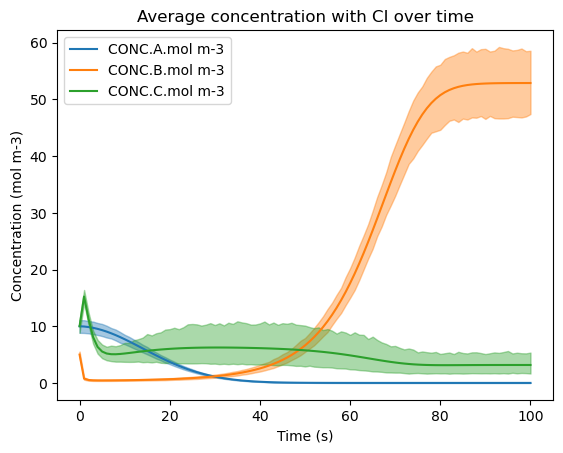

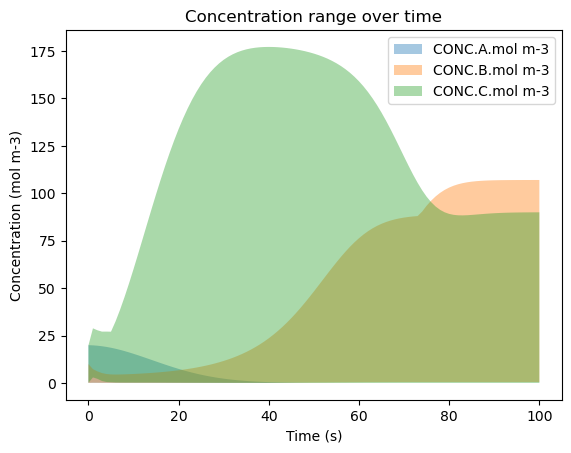

In [6]:
state.set_conditions(temperatures, pressures)
state.set_concentrations(concentrations)
concentrations_solved = []
time_step_length = 1
sim_length = 100
curr_time = 0

while curr_time <= sim_length:
    solver.solve(state, curr_time)
    concentrations_solved.append(state.get_concentrations())
    curr_time += time_step_length

concentrations_solved_expanded = []
time = []
for i in range(0, sim_length + 1, time_step_length):
    for j in range(0, num_grid_cells):
        concentrations_solved_expanded.append({key: value[j] for key, value in concentrations_solved[int(i/time_step_length)].items()})
        time.append(i)
df_expanded = pd.DataFrame(concentrations_solved_expanded)
df_expanded = df_expanded.rename(columns = {'A' : 'CONC.A.mol m-3', 'B' : 'CONC.B.mol m-3', 'C' : 'CONC.C.mol m-3'})
df_expanded['time.s'] = time
df_expanded['ENV.temperature.K'] = np.repeat(temperatures[0], (sim_length/time_step_length + 1.0) * num_grid_cells)
df_expanded['ENV.pressure.Pa'] = np.repeat(pressures[0], (sim_length/time_step_length + 1.0) * num_grid_cells)
df_expanded['ENV.air number density.mol m-3'] = np.repeat(state.get_conditions()['air_density'][0], (sim_length/time_step_length + 1.0) * num_grid_cells)
df_expanded = df_expanded[['time.s', 'ENV.temperature.K', 'ENV.pressure.Pa', 'ENV.air number density.mol m-3', 'CONC.A.mol m-3', 'CONC.B.mol m-3', 'CONC.C.mol m-3']]
display(df_expanded)

sns.lineplot(data=df_expanded, x='time.s', y='CONC.A.mol m-3', errorbar=('ci', 95), err_kws={'alpha' : 0.4}, label='CONC.A.mol m-3')
sns.lineplot(data=df_expanded, x='time.s', y='CONC.B.mol m-3', errorbar=('ci', 95), err_kws={'alpha' : 0.4}, label='CONC.B.mol m-3')
sns.lineplot(data=df_expanded, x='time.s', y='CONC.C.mol m-3', errorbar=('ci', 95), err_kws={'alpha' : 0.4}, label='CONC.C.mol m-3')
plt.title('Average concentration with CI over time')
plt.ylabel('Concentration (mol m-3)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

min_y = []
max_y = []
for i in range(0, sim_length + 1, time_step_length):
        min_y.append({key: np.min(value) for key, value in concentrations_solved[int(i/time_step_length)].items()})
        max_y.append({key: np.max(value) for key, value in concentrations_solved[int(i/time_step_length)].items()})
time_x = list(map(float, range(0, sim_length + 1, time_step_length)))

plt.fill_between(time_x, [y['A'] for y in min_y], [y['A'] for y in max_y], alpha = 0.4, label='CONC.A.mol m-3')
plt.fill_between(time_x, [y['B'] for y in min_y], [y['B'] for y in max_y], alpha = 0.4, label='CONC.B.mol m-3')
plt.fill_between(time_x, [y['C'] for y in min_y], [y['C'] for y in max_y], alpha = 0.4, label='CONC.C.mol m-3')
plt.title('Concentration range over time')
plt.ylabel('Concentration (mol m-3)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()